In [2]:
import os, sys
sys.path.append("..")

In [3]:
from unet import UNet
import torch.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import writer 
import matplotlib.pyplot as plt
import torch
import numpy as np
from datasets import CifarDataset, cifar_data_transform, show_images_batch
from diffusion import get_noise_schedule, show_images_batch, one_step_denoising, cifar_data_transform, forward_diffusion
import tqdm

In [4]:
device = "cuda:1"

## Init model

In [5]:
model = UNet(
        init_channels=32,
        in_channels=3,
        out_channels=3,
        num_res_blocks=2,
        attn_resolutions=(
            16,
        ),
        input_img_resolution=32,
        channels_multipliers=(1, 2, 2, 2),
    ).to(device)

### Init dataset

In [6]:
# Init dataset
batch_size = 2
data_transform = cifar_data_transform()
data = CifarDataset(
    img_dir="/home/anvuong/Desktop/datasets/CIFAR-10-images/train",
    classes="all",
    transform=data_transform,
)
loader = DataLoader(data, batch_size=batch_size, drop_last=True)

In [11]:
# Init diffusion params
T = 500
betas = get_noise_schedule(T)
alphas = 1 - betas
alphas_cum = torch.cumprod(alphas, dim=0)

# repeat into batch_size for easier indexing by t
betas = betas.unsqueeze(0).repeat(batch_size, 1).to(device)
alphas = alphas.unsqueeze(0).repeat(batch_size, 1).to(device)
alphas_cum = alphas_cum.unsqueeze(0).repeat(batch_size, 1).to(device)

timestep 1


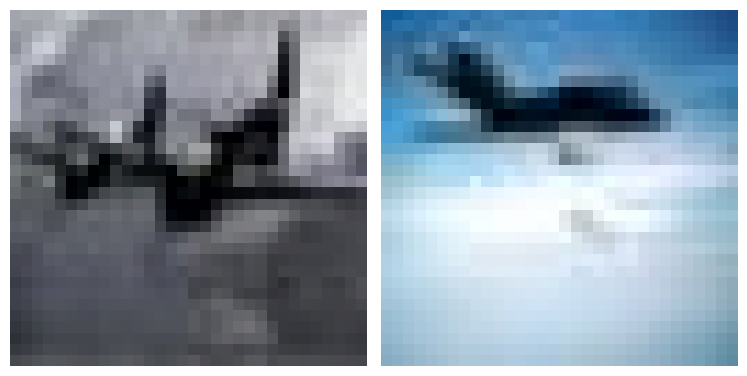

timestep 21


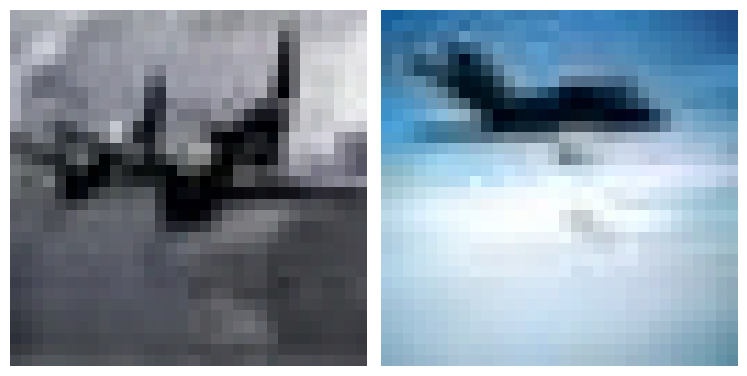

timestep 41


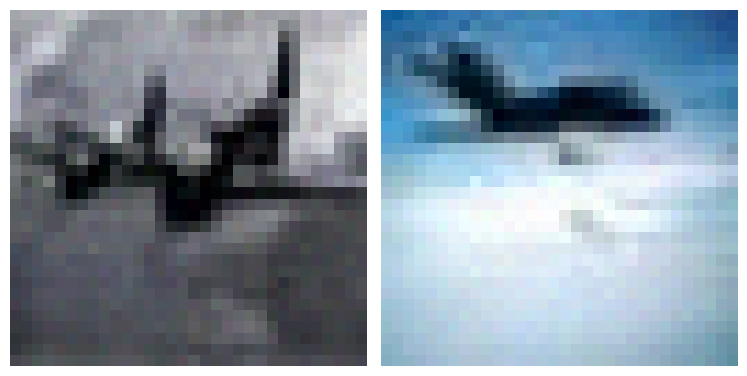

timestep 61


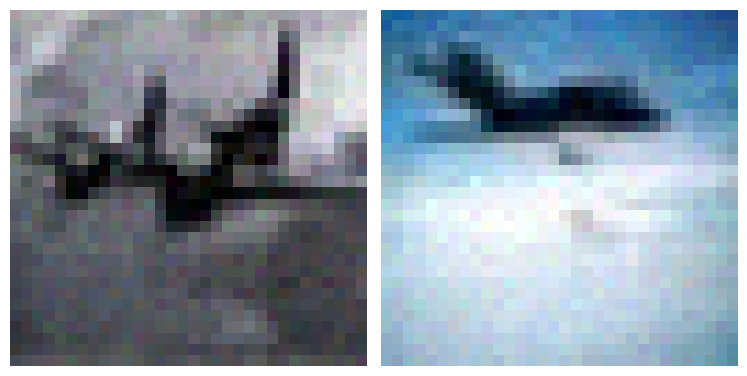

timestep 81


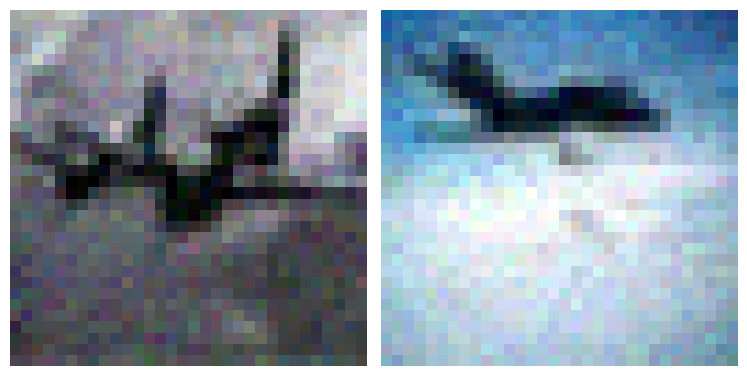

timestep 101


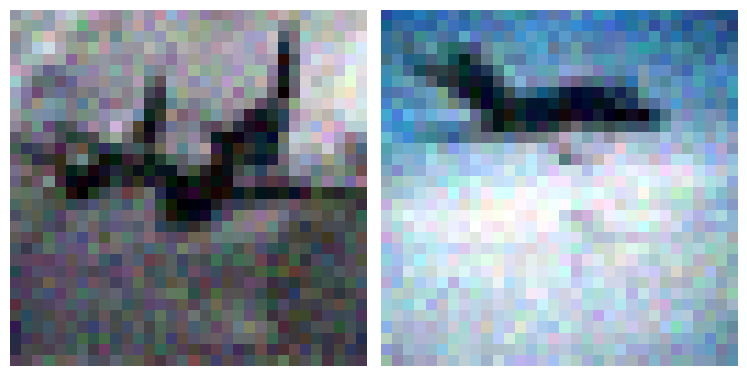

timestep 121


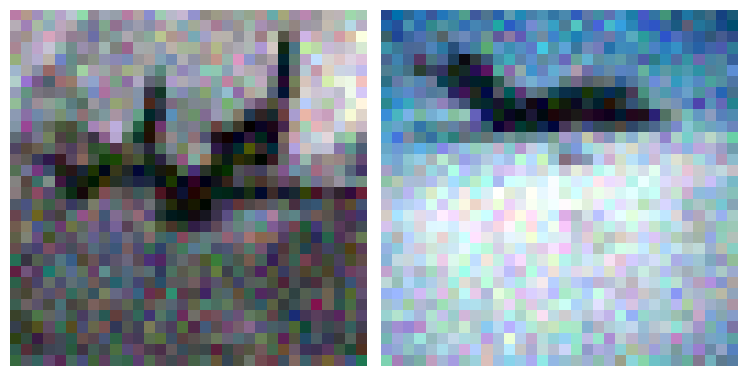

timestep 141


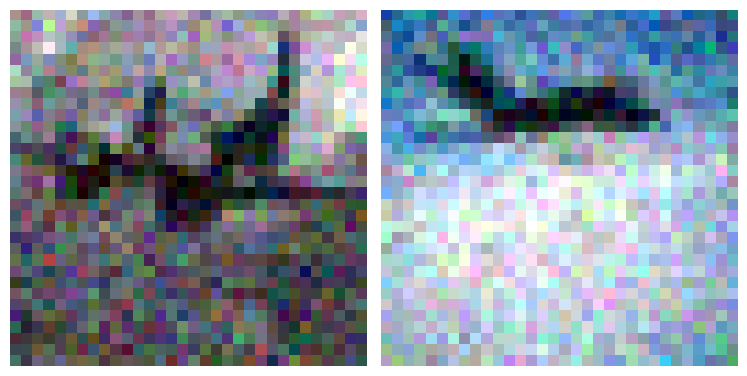

timestep 161


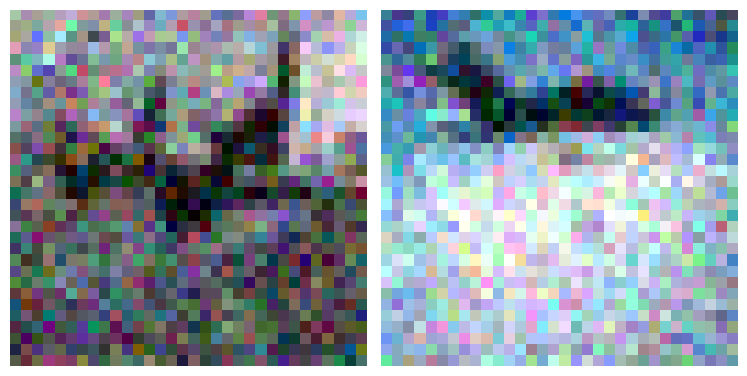

timestep 181


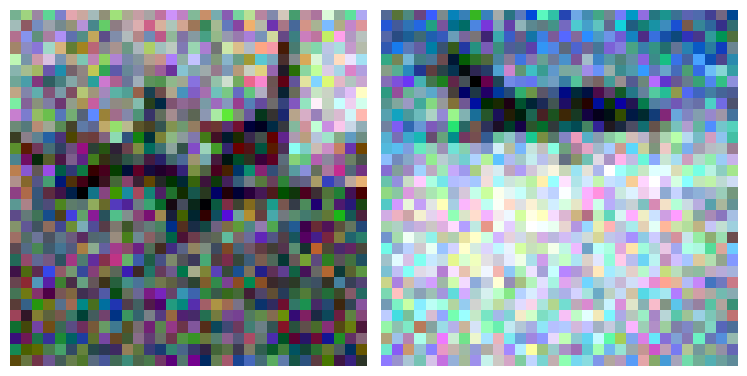

timestep 201


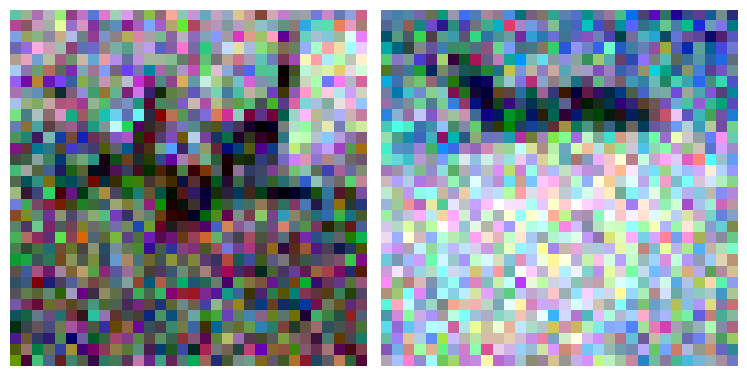

timestep 221


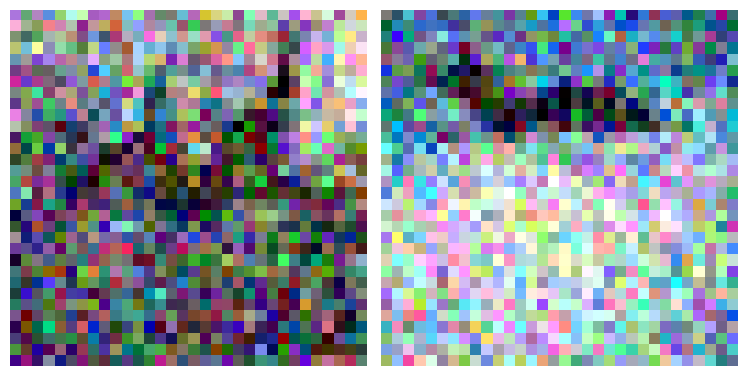

timestep 241


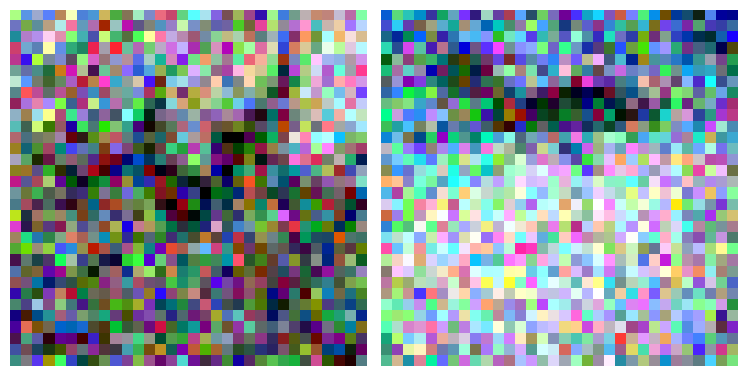

timestep 261


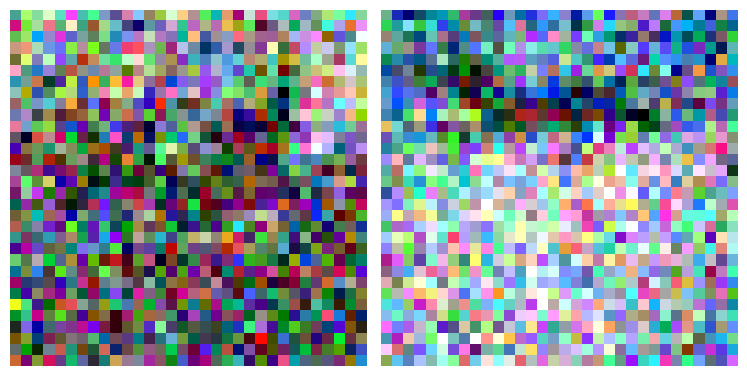

timestep 281


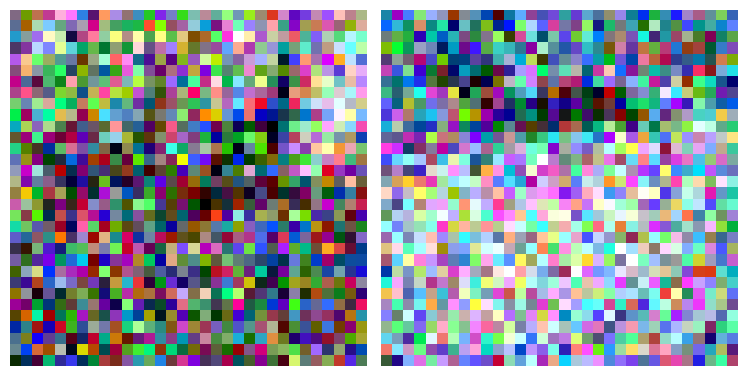

timestep 301


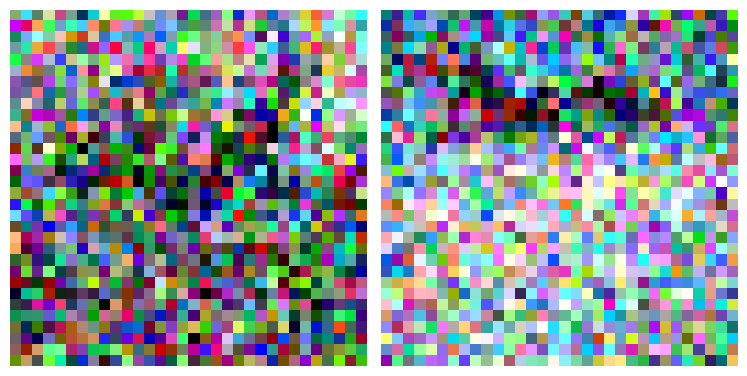

timestep 321


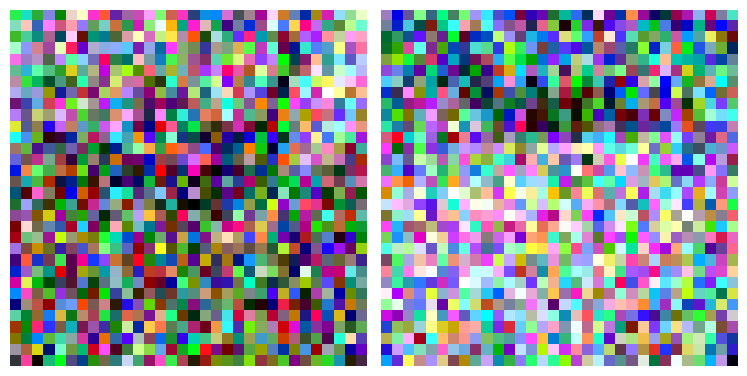

timestep 341


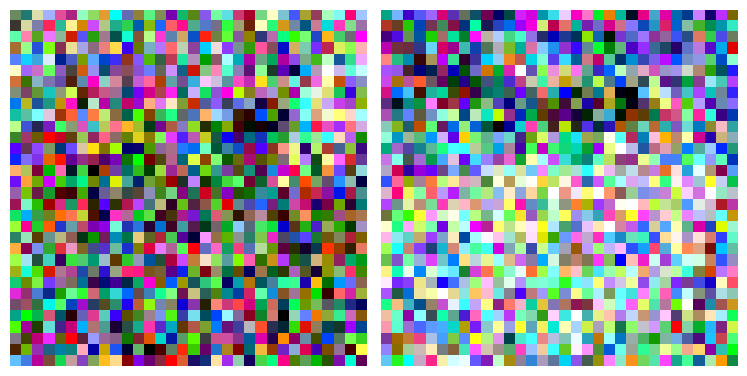

timestep 361


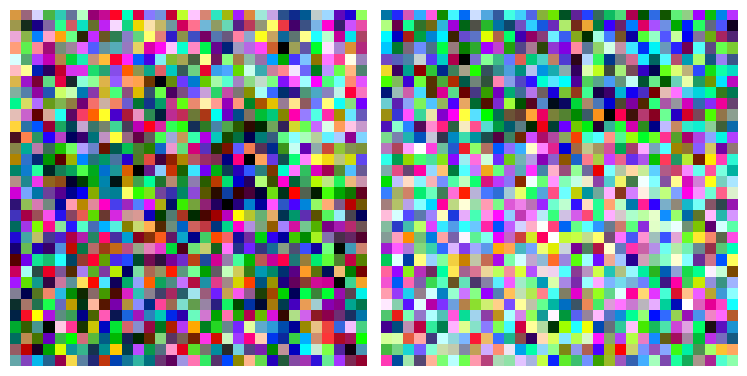

timestep 381


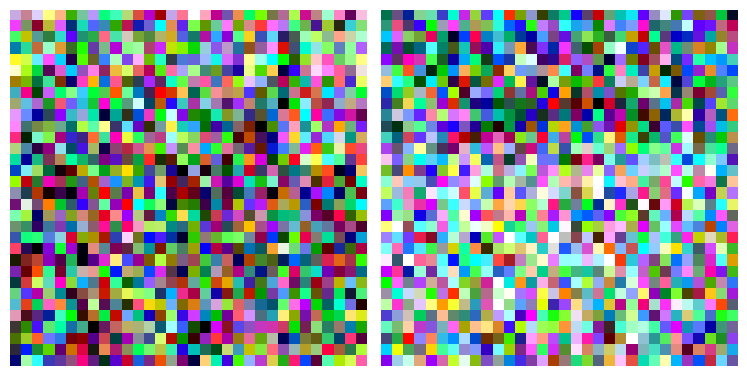

timestep 401


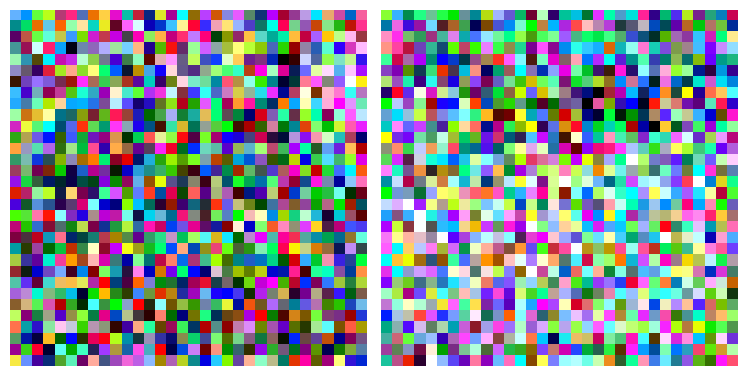

timestep 421


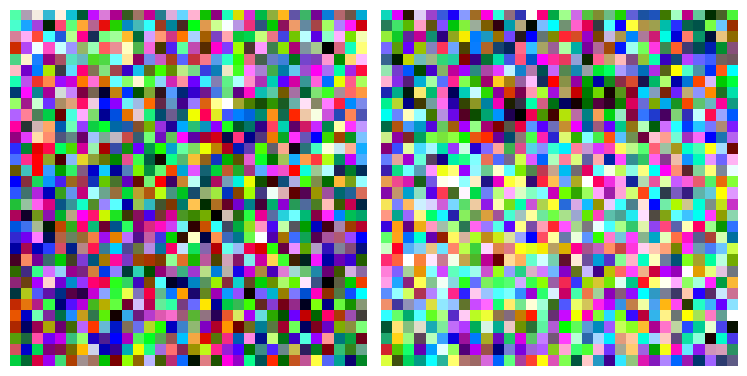

timestep 441


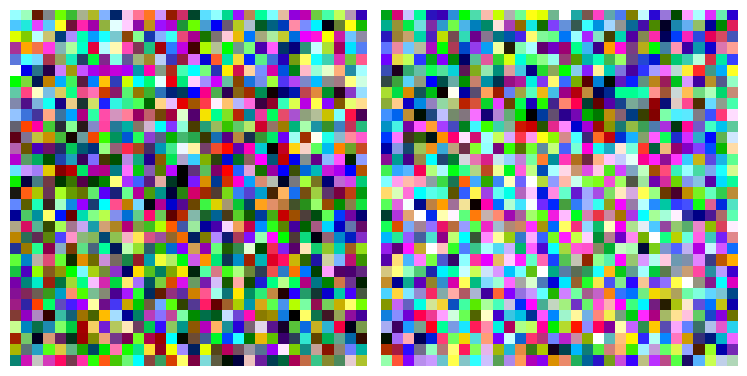

timestep 461


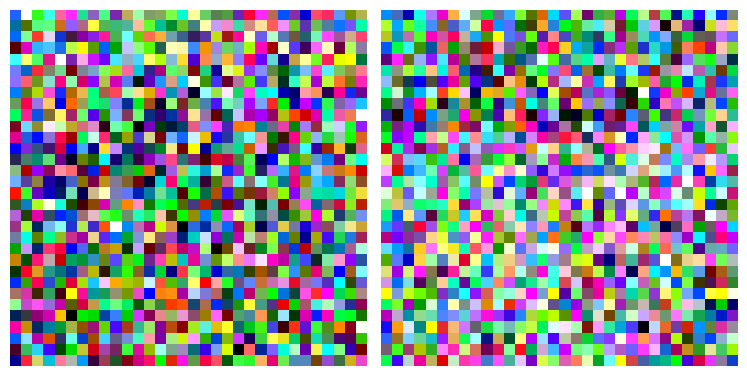

timestep 481


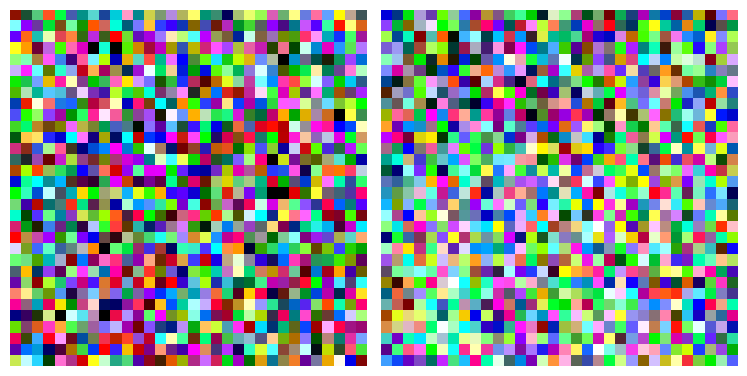

In [12]:
# Get a sample batch
x = next(iter(loader))
x = x.to(device)

for t_ in np.arange(1, T, 20):
    t = torch.ones(size=(batch_size, 1), dtype=int)*t_
    t = t.to(device)
    x_in, noise_in = forward_diffusion(x, t, alphas_cum, device=device)

    show_images_batch(None, x_in.cpu())
    print("timestep", t_)
    plt.show()

In [9]:
t = torch.ones(size=(batch_size, 1), dtype=int)*100
t = t.to(device)
x_in, noise_in = forward_diffusion(x, t, alphas_cum, device=device)

In [9]:
t.squeeze().shape

torch.Size([2])

In [10]:
input_names = ['image', 'time']
output_names = ['noise']
torch.onnx.export(model, {"x_in":x_in, "t_in":t.squeeze()}, 'model.onnx',
                  input_names=input_names, output_names=output_names)

/home/anvuong/Desktop/codes/ddpm_torch/notebooks/../unet.py:366: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert x.shape[2] == self.input_img_resolution  # square image
/home/anvuong/Desktop/codes/ddpm_torch/notebooks/../unet.py:367: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert x.shape[3] == self.input_img_resolution  # square image
/home/anvuong/Desktop/codes/ddpm_torch/notebooks/../unet.py:32: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so t